In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import dynamical_systems_routines as dsr
import my_causation_entropy_builder as my_ceb
import knn_mi_comp as mi 

%matplotlib inline

In [2]:
def windowed_deprecation(dep_fac, tseries):
    ndims, nstps = tseries.shape
    avg_window = np.ones((dep_fac,1))/dep_fac
    n_dep_stps = int(np.floor(nstps/dep_fac))
    
    tseries_dep = np.zeros((ndims, 2*n_dep_stps))
    for jj in range(n_dep_stps):
        tseries_dep[:, 2*jj] = np.squeeze(tseries[:, jj*dep_fac:(jj+1)*dep_fac] @ avg_window)            
        if jj < n_dep_stps-1:
            tseries_dep[:, 2*jj+1] = np.squeeze(
                tseries[:, int(dep_fac/2) + jj*dep_fac:int(dep_fac/2) + (jj+1)*dep_fac] @ avg_window)            
    
    #tavg = np.mean(tseries_dep, axis=1)
    #for kk in range(ndims):
    #    var = np.sqrt(np.mean( (tseries_dep[kk, :] - tavg[kk])**2. ))
    #    tseries_dep[kk, :] = (tseries_dep[kk, :]-tavg[kk])/var

    return tseries_dep

In [ ]:
coupling_strength = 1.
dt = .01
coupled_data = dsr.generate_coupled(x1min=-2, x1max=2, x2min=-2, x2max=2, x3min=-2, x3max=2, num_ic=10, dt=dt, tf=150.0, coupling=coupling_strength, delay=0)

Generating Coupled Lorenz-Rossler system data...: 100%|█████████████| 10/10 [00:01<00:00,  5.67it/s]


In [4]:
rscled_data = np.zeros((coupled_data.shape[0], coupled_data.shape[1], coupled_data.shape[2]))
for jj in range(coupled_data.shape[0]):
    avg = np.tile(np.mean(np.squeeze(coupled_data[jj, :, :]), axis=1).reshape(-1, 1), (1, coupled_data.shape[2]))
    rscled_data[jj, :, :]  = coupled_data[jj, :, :] - avg
    rscled_var = np.sqrt(np.tile(np.mean( rscled_data[jj, :, :]**2., axis=1 ).reshape(-1,1), (1,coupled_data.shape[2])))
    rscled_data[jj, :, :] /= rscled_var

In [5]:
traj = 9
skp = int(np.round(120/dt))

In [6]:
def it_lag_graph(tseries, max_lag, kneighbor):
    ndims = tseries.shape[0]
    osteps_it = np.zeros((ndims, max_lag), dtype=np.float64)
    for jj in range(ndims):
        for ll in range(1, max_lag+1):
            forward = tseries[jj, ll:].reshape(-1,1)
            backward = tseries[jj, :-ll].reshape(-1,1) 
            osteps_it[jj, ll-1] = mi.miknn(forward, backward, kneighbor)
        
    return osteps_it

In [7]:
dep = 5
avg_data = coupled_data[traj, :, skp::dep]
rscl_data = rscled_data[traj, :, skp::dep]

max_lag = 12

kneighbor = 3
osteps_it_rscl = it_lag_graph(rscl_data, max_lag=max_lag, kneighbor=kneighbor)

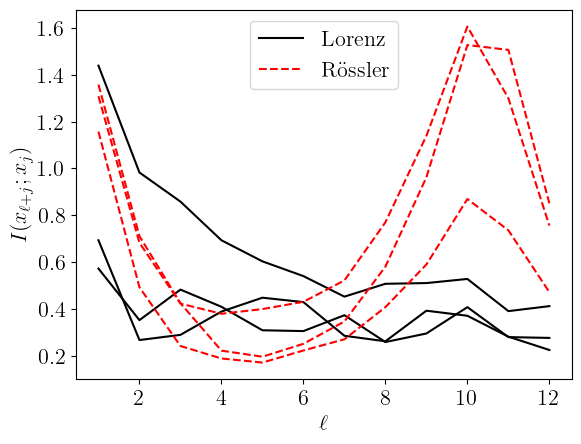

In [8]:
lags = np.arange(1, max_lag+1, dtype=int)
for jj in range(6):
    if jj < 3:
        if jj == 0:
            plt.plot(lags, osteps_it_rscl[jj, :], c='k', label=r"Lorenz")
        else:
            plt.plot(lags, osteps_it_rscl[jj, :], c='k')
    else:
        if jj == 3:
            plt.plot(lags, osteps_it_rscl[jj, :], c='r', ls='--', label=r"R\"{o}ssler")
        else:
            plt.plot(lags, osteps_it_rscl[jj, :], c='r', ls='--')
plt.xlabel(r"$\ell$")
plt.ylabel(r"$I(x_{\ell+j};x_{j})$")
plt.legend()
plt.savefig("Lorenz_Rossler_lag_test_Cval_" + str(coupling_strength)
            +"_max_lag_"+str(max_lag) 
            + "_dep_" + str(dep) + ".pdf", dpi=150, bbox_inches='tight')  

In [25]:
#ax = plt.figure().add_subplot(projection='3d')
#ax.plot(avg_data[0, :], avg_data[1, :], avg_data[2, :], lw=0.5)

In [26]:
#ax = plt.figure().add_subplot(projection='3d')
#ax.plot(avg_data[3, :], avg_data[4, :], avg_data[5, :], lw=0.5)

In [33]:
alpha_m = .05
max_lag = 1
kneighbor = 3
results_graph_rscl = my_ceb.Model_Graph(data=rscl_data, max_lag=max_lag, kneighbor=kneighbor, alpha_m=alpha_m)
results_graph_rscl.et_graph_model_builder()

For target 0
Target model: [1]
Chosen sources: [[1, 3, 4]]
Final information content of model: 1.4056269297148178

For target 1
Target model: [1]
Chosen sources: [[1, 3, 4], [0, 2, 4]]
Final information content of model: 1.213009079090232

For target 2
Target model: [1]
Chosen sources: [[1, 3, 4], [0, 2, 4], [1, 0, 4]]
Final information content of model: 0.8954055272246991

For target 3
Target model: [1]
Chosen sources: [[1, 3, 4], [0, 2, 4], [1, 0, 4], [4, 1, 5]]
Final information content of model: 1.065848450396201

For target 4
Target model: [1]
Chosen sources: [[1, 3, 4], [0, 2, 4], [1, 0, 4], [4, 1, 5], [3]]
Final information content of model: 1.3144464452389832

For target 5
Target model: [1]
Chosen sources: [[1, 3, 4], [0, 2, 4], [1, 0, 4], [4, 1, 5], [3], [3]]
Final information content of model: 0.6874458848991308



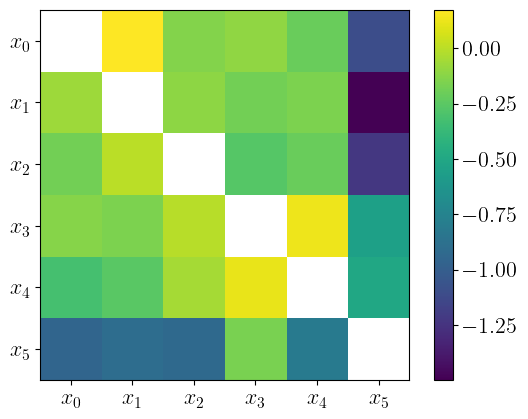

In [34]:
results_graph_rscl.mat_visualizer(results_graph_rscl.source_info_mat, 'x', True, 'viridis')
plt.savefig("Lorenz_Rossler_source_info_Cval_" + str(coupling_strength)
            + "_pval_"+str(alpha_m)+"_max_lag_"+str(max_lag) 
            + "_dep_" + str(dep) + ".pdf", dpi=150, bbox_inches='tight')  

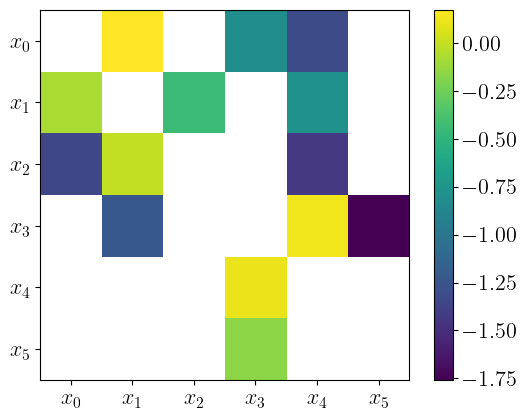

In [35]:
results_graph_rscl.mat_visualizer(results_graph_rscl.te_mat, 'x', True, 'viridis')
plt.savefig("Lorenz_Rossler_tevals_Cval_" + str(coupling_strength)
            + "_pval_"+str(alpha_m)+"_max_lag_"+str(max_lag) 
            + "_dep_" + str(dep) + ".pdf", dpi=150, bbox_inches='tight')  

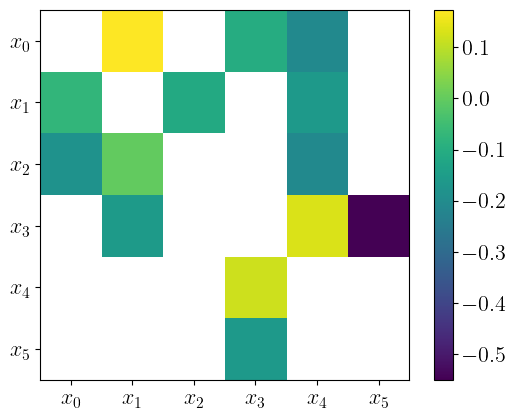

In [36]:
results_graph_rscl.mat_visualizer(results_graph_rscl.it_mat, 'x', True, 'viridis')
plt.savefig("Lorenz_Rossler_itvals_Cval_" + str(coupling_strength)
            + "_pval_"+str(alpha_m)+"_max_lag_"+str(max_lag) 
            + "_dep_" + str(dep) + ".pdf", dpi=150, bbox_inches='tight')  

[[1, 3, 4], [0, 2, 4], [1, 0, 4], [4, 1, 5], [3], [3]]


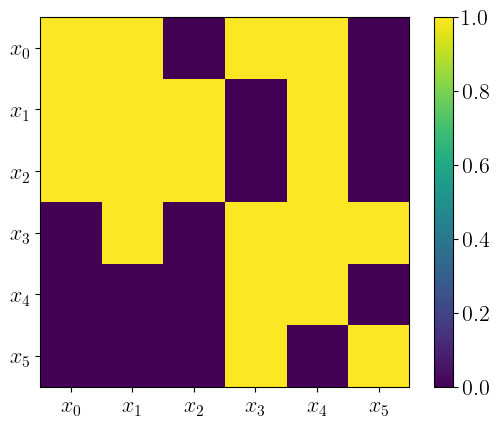

In [37]:
lag_matrix = np.zeros((6, 6), dtype=int)
for cnt, target in enumerate(results_graph_rscl.target_models):
    lag_matrix[cnt, cnt] = max(target.model)

all_original_indices = results_graph_rscl.chosen_sources_original_indices
print(all_original_indices)
for cnt, best_e_graph in enumerate(results_graph_rscl.source_models):
    my_original_indices = all_original_indices[cnt]
    for next_cnt, source_label in enumerate(best_e_graph.chosen_sources):
        lag_matrix[cnt, my_original_indices[next_cnt]] = max(best_e_graph.sources[source_label].model)

results_graph_rscl.mat_visualizer(lag_matrix, 'x', False, 'viridis')
plt.savefig("Lorenz_Rossler_lags_Cval_" + str(coupling_strength) + "_max_lag_" + str(max_lag) + ".pdf", dpi=150, bbox_inches='tight')  